# Protein deep learning

Although proteins are more of an interest for bioinformaticians than for cheminformaticians, they are a crucial element of drug design. Especially the 3D structure of proteins is very important because of its connection to the functioning of these biological machines in the organism.

## Protein representations

Proteins are chemical compounds, but considering their huge volume, they are often processed in a different way than small molecules. Typical representations are:

1. **Amino acid sequence** - proteins are strings of amino acids that can be represented as text, and by adding information about dihedral angles we can encode spatial information; we can process this representation using recurrent neural networks or transformers;
![dihedrals](https://upload.wikimedia.org/wikipedia/commons/c/c0/Protein_backbone_PhiPsiOmega_drawing.jpg)
2. **Graphs** - this representation is similar to molecular graphs known from the previous notebooks, but in this case to simplify the structure, only α carbons are represented encoding their amino acid residue; this representation can be processed using graph neural networks;
3. **Voxel grids** - this representation is constructed by surrounding the protein with a voxel grid (cubes that encode atoms they intersect); usually the voxel size can be set to 1 Å^3 (1 Å = 10^-10 m); this representation can be processed using 3D convolutional neural networks;
![voxel](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0221347.g002&type=large)
4. **Distance or contact maps** - two-dimensional representation that represents distances between alpha carbons; we can binarize these distances using a selected threshold value, and such maps are called contact maps; this representation can be processed using (2D) convolutional neural networks;
![contact](https://upload.wikimedia.org/wikipedia/commons/8/8d/Protein_Contact_Map%2C_2-Color%2C_2QIP-A.png)
5. **Point clouds** - sets of not connected points (alpha carbons) encoding selected features (e.g. amino acid codes); this representation can be processed by neural networks adapted to processing point clouds, which are similar to graph neural networks;
6. **Meshes** - in this representation we only encode features of the protein surface; a graph is constructed by sampling a grid of points on the surface of proteins (a mesh), and the nodes can encode features related to the amino acids in the vicinity; this representation can be processed by graph neural networks.

## Problems that can be solved

1. **Inverse protein folding**, also known as protein design - a task that aims to find an amino acid sequence that folds to a given 3D structure;
2. **Binding site detection** - discovering cavities in proteins that can be used as binding sites for ligands; it can be realized as 3D grid segmentation using 3D convolutions (e.g. U-Net);
3. **Binding affinity prediction** - evaluation of the binding affinity given the ligand-protein complex (e.g. a ligand docked to the crystal structure of a protein).
4. **protein-based *de novo* design** - designing new ligands that match the binding site of a given protein.
![deepsite](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSv_unCC0dhDSQWwQipcKQSEulT064aq-WOnQ&usqp=CAU)

**Exercise 1:** Implement one of the representations above (the code below can be used to implement 3D voxel grids).

**Zadanie 2:** Implement a network that processes this representation (you don't need to train it, it should only return a correct output). In the case of voxel grids: check if your voxel grid can be passed through a 3D convolution (imported from PyTorch), and the output shape is what you expected.

## Przykładowy fragment implementacji wokseli

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [7]:
symbols = ['C', 'N', 'O', 'S']

### You need to install https://github.com/BioPandas/biopandas

In [8]:
from biopandas.pdb import PandasPdb
pl1 = PandasPdb().read_pdb('../L4-molecular-docking/4ivt.pdb')

In [9]:
bound_1 = max(pl1.df["ATOM"]["x_coord"].max(), pl1.df["ATOM"]["y_coord"].max(), pl1.df["ATOM"]["z_coord"].max())
bound_2 = min(pl1.df["ATOM"]["x_coord"].min(), pl1.df["ATOM"]["y_coord"].min(), pl1.df["ATOM"]["z_coord"].min())

In [10]:
pos = np.empty((pl1.df["ATOM"].shape[0], 3))  # Create a position matrix of dimensions number_of_atoms x 3
# bounding_box = (bound_1, bound_2)  # Create a bounding box definition, e.g. two corners of the protein bounding box
unit = 1
box_size = round((bound_1 - bound_2) / unit) + 1
grid = np.empty((box_size, box_size, box_size, len(symbols)))

In [11]:
def map_cords_to_indices(
    x_cord: float, 
    y_cord: float, 
    z_cord: float, 
    bound_low: float, 
    bound_high: float, 
    unit: float,
) -> tuple[int, int, int]:
    x = round((x_cord - bound_low) / unit)
    y = round((y_cord - bound_low) / unit)
    z = round((z_cord - bound_low) / unit)
    return x, y, z

In [12]:
for x_coord, y_coord, z_coord, atom in pl1.df["ATOM"][["x_coord", "y_coord", "z_coord", "atom_name"]].itertuples(index=False):
    if atom not in symbols:
        continue
    x, y, z = map_cords_to_indices(x_coord, y_coord, z_coord, bound_2, bound_1, unit)
    grid[x, y, z, symbols.index(atom)] = 1  # Map atoms onto the grid, use 1 to mark the corresponding grid position and channel
    # tip: you will need the atom symbol and atom position aligned with the grid

<IPython.core.display.Javascript object>


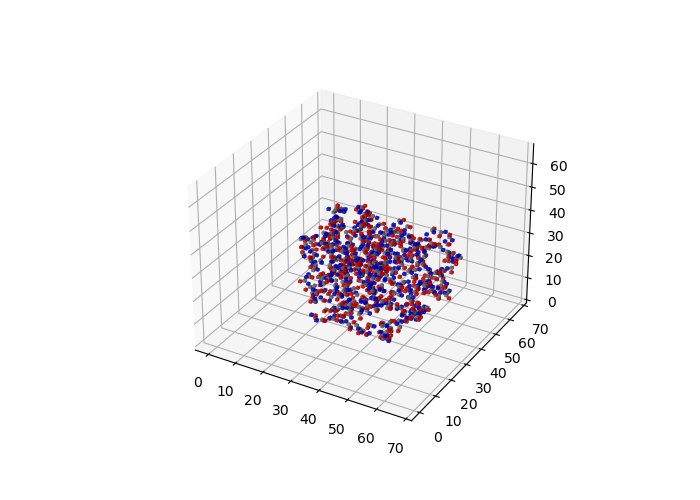

In [13]:
# The code below will plot your voxel grid
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(grid[:, :, :, 0], facecolors='grey', alpha=0.7)
ax.voxels(grid[:, :, :, 1], facecolors='blue', alpha=0.7)
ax.voxels(grid[:, :, :, 2], facecolors='red', alpha=0.7)
ax.voxels(grid[:, :, :, 3], facecolors='orange', alpha=0.7)
plt.show()

## Ex 2

In [17]:
from torch import nn, from_numpy

In [23]:
m = nn.Conv3d(box_size, 33, 3, stride=2)

In [24]:
m(from_numpy(grid).float())

tensor([[[[-0.0137],
          [-0.0137],
          [-0.0137],
          ...,
          [-0.0137],
          [-0.0137],
          [-0.0137]],

         [[-0.0137],
          [-0.0137],
          [-0.0137],
          ...,
          [-0.0137],
          [-0.0137],
          [-0.0137]],

         [[-0.0137],
          [-0.0137],
          [-0.0137],
          ...,
          [-0.0137],
          [-0.0137],
          [-0.0137]],

         ...,

         [[-0.0137],
          [-0.0137],
          [-0.0137],
          ...,
          [-0.0137],
          [-0.0137],
          [-0.0137]],

         [[-0.0137],
          [-0.0137],
          [-0.0137],
          ...,
          [-0.0137],
          [-0.0137],
          [-0.0137]],

         [[-0.0137],
          [-0.0137],
          [-0.0137],
          ...,
          [-0.0137],
          [-0.0137],
          [-0.0137]]],


        [[[-0.0077],
          [-0.0077],
          [-0.0077],
          ...,
          [-0.0077],
          [-0.0077],
     